In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt


In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def build_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    bottleneck = layers.MaxPooling2D((2, 2), padding='same')(x)  # Bottleneck (7, 7, 16)

    # Decoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(bottleneck)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    encoder = models.Model(input_img, bottleneck)
    return autoencoder, encoder


In [4]:
autoencoder, encoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test),
                          callbacks=[early_stopping])


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.3997 - val_loss: 0.3045
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3008 - val_loss: 0.2988
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2966 - val_loss: 0.2963
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2937 - val_loss: 0.2947
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2923 - val_loss: 0.2938
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2911 - val_loss: 0.2923
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2906 - val_loss: 0.2917
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2887 - val_loss: 0.2909
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2888 - val_loss: 0.2904
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2876 - val_loss: 0.2896
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2875 - val_loss: 0.2898
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/st

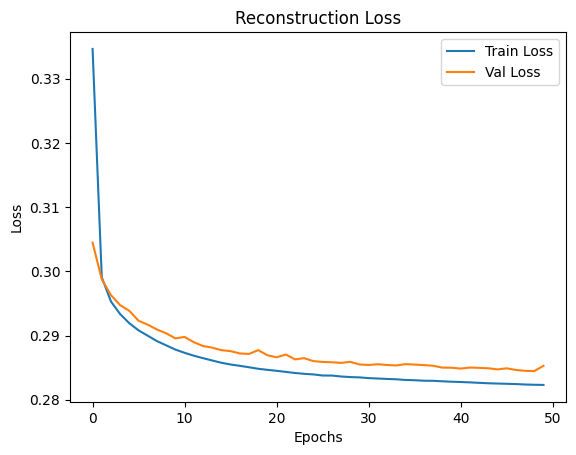

In [5]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


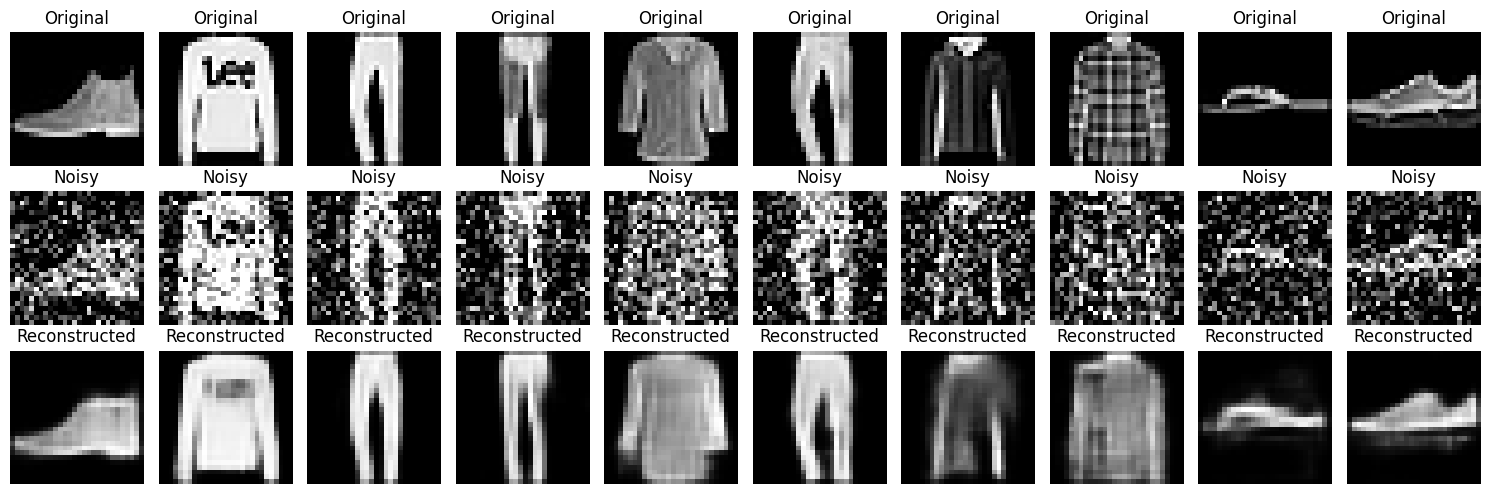

In [6]:
decoded_imgs = autoencoder.predict(x_test_noisy[:10])

plt.figure(figsize=(15, 5))
for i in range(10):
    # Original
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy
    ax = plt.subplot(3, 10, i + 11)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(3, 10, i + 21)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


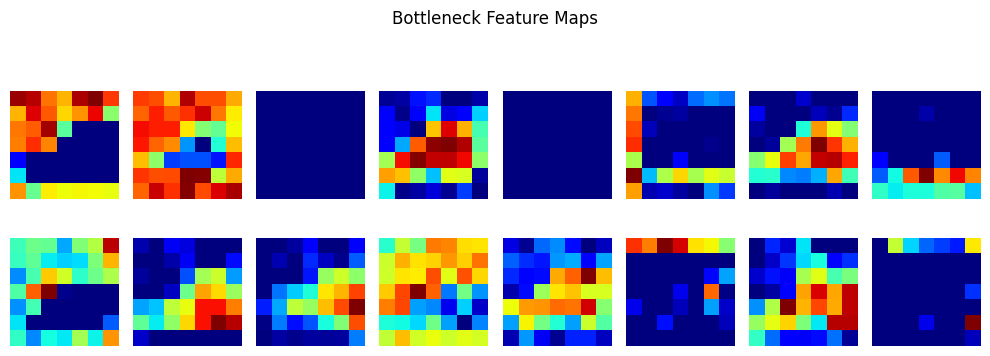

In [8]:
bottleneck_features = encoder.predict(x_test_noisy[:10])

# Plot feature maps of the first image (7x7x16 -> 16 channels)
plt.figure(figsize=(10, 4))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(bottleneck_features[0, :, :, i], cmap='jet')
    plt.axis('off')
plt.suptitle("Bottleneck Feature Maps")
plt.tight_layout()
plt.show()



* A **Denoising Autoencoder** was built using the **Fashion MNIST** dataset.
* The model uses **convolutional layers** to compress and then reconstruct images.
* **Noise was added** to the images, and the model learned to **remove the noise**.
* The **bottleneck layer** captures the important features in a compressed form.
* **Visualized**:

  * Original, noisy, and denoised images
  * The **bottleneck (latent space)**
  * The **training loss graph**
* **EarlyStopping** was used to stop training when the model stopped improving.
* The model **successfully denoised images** and learned important patterns.
